In [ ]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt

from math import sqrt
from scipy.stats import gaussian_kde
from scipy.optimize import curve_fit
from scipy.special import gamma as gamma_function

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install scipy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

- Написать про каждый столбец.
- Написать, как изменились столбцы.

In [ ]:
lunar = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/University/Multivariate/lunar.csv')

In [ ]:
lunar.sample(5)

,Catalog Number,Calendar Date,Eclipse Time,Delta T (s),Lunation Number,Saros Number,Eclipse Type,Quincena Solar Eclipse,Gamma,Penumbral Magnitude,Umbral Magnitude,Latitude,Longitude,Penumbral Eclipse Duration (m),Partial Eclipse Duration (m),Total Eclipse Duration (m)
9089,9090,1767 August 10,00:02:55,16,-2875,144,N,a-,1.4447,0.1826,-0.7690,14S,0E,113.2,-,-
325,326,-1866 April 28,05:02:45,43261,-47813,11,P,h-,-0.4893,1.9696,0.9507,8S,104E,333.7,198,-
4169,4170,-270 December 15,10:22:56,13600,-28065,40,N,-t,-1.1425,0.8145,-0.2905,22N,99W,262.8,-,-
7631,7632,1165 May 27,12:52:52,837,-10323,107,P,a-,-0.4727,1.9823,0.9986,23S,169E,319.5,194.5,-
5406,5407,241 July 10,15:10:04,8206,-21750,62,P,-t,-0.8980,1.2284,0.1922,23S,167E,293.7,102,-


Step 1. Choosen subsample with main variables for further analysis

In [ ]:
subsample = lunar[['Gamma', 'Penumbral Magnitude', 'Umbral Magnitude']]

In [ ]:
subsample.sample(5)

,Gamma,Penumbral Magnitude,Umbral Magnitude
1180,-0.9901,1.0858,-0.0025
2405,-0.9331,1.1335,0.1579
4117,-0.2822,2.3304,1.3498
8595,1.0535,0.9582,-0.1079
3768,-1.0910,0.8898,-0.1771


### Gamma

Step 2. Non-parametric estimation of PDF in form of histogram and using kernel density function

In [ ]:
gamma = subsample['Gamma']

In [ ]:
def get_bin_count(feature):
    n = feature.shape[0]
    return np.round(5 * np.log(n)).astype('int')

In [ ]:
n_bins = get_bin_count(gamma)

In [ ]:
def hist_and_kde(feature, label):
    density = gaussian_kde(feature)
    xgrid = np.linspace(feature.min(), feature.max(), n_bins)
    plt.figure(figsize=(7, 5))
    plt.hist(feature, bins=n_bins, density=True)
    plt.plot(xgrid, density(xgrid), 'r-')
    plt.xlabel(label)
    plt.ylabel('Density')

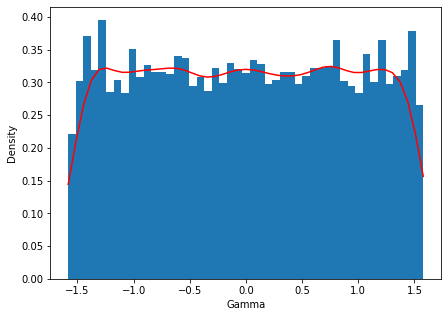

In [ ]:
hist_and_kde(gamma, 'Gamma')

Step 3. Estimation of order statistics and their representation as boxplot.

In [ ]:
def get_max_min(feature):
    feature_max = feature.max()
    feature_min = feature.min()
    print(f'{feature_max} - max number of {feature.name}')
    print(f'{feature_min} - min number of {feature.name}')

In [ ]:
get_max_min(gamma)

1.5791 - max number of Gamma
-1.5827 - min number of Gamma


In [ ]:
percs = np.linspace(0, 100, 5)

In [ ]:
# Calculating confidence intervals for 25%, 50% and 75% quantiles
def conf_intervals(data, qn):
    # 95% quantile of Gaussian distribution
    norm_q95 = st.norm.ppf(0.95)
    kernel = gaussian_kde(data)

    p25 = len(data[data < qn[1]]) / len(data)
    sigma25 = (sqrt((p25 * (1 - p25)) / len(data))) / kernel(qn[1])
    p50 = len(data[data < qn[2]]) / len(data)
    sigma50 = (sqrt((p50 * (1 - p50)) / len(data))) / kernel(qn[2])
    p75 = len(data[data < qn[3]]) / len(data)
    sigma75 = (sqrt((p75 * (1 - p75)) / len(data))) / kernel(qn[3])

    conf_q25 = norm_q95 * sigma25
    conf_q50 = norm_q95 * sigma50
    conf_q75 = norm_q95 * sigma75
    
    conf_ints = [conf_q25[0], conf_q50[0], conf_q75[0]]

    for qn_, conf_ints_, perc_ in zip(qn[1:4], conf_ints, percs[1:4]):
        print(f'{qn_:.3f} +/- {conf_ints_:.3f} - confidence interval for {perc_}% quantile at 95% confidence level')

    return conf_ints

In [ ]:
qn = np.percentile(gamma, percs)
p_conf_intervals = conf_intervals(gamma, qn)

-0.789 +/- 0.020 - confidence interval for 25.0% quantile at 95% confidence level
0.002 +/- 0.023 - confidence interval for 50.0% quantile at 95% confidence level
0.792 +/- 0.020 - confidence interval for 75.0% quantile at 95% confidence level


In [ ]:
def get_boxplot(feature, qn, p_conf_intervals):
    plt.figure(figsize=(20, 5))
    plt.boxplot(feature, vert=False)
    plt.errorbar(
        # [25%, 50%, 75%]
        qn[1:4],
        [1, 1, 1],
        xerr=p_conf_intervals,
        yerr=[0, 0, 0],
        ls='none',
        capsize=3,
        elinewidth=2
    )

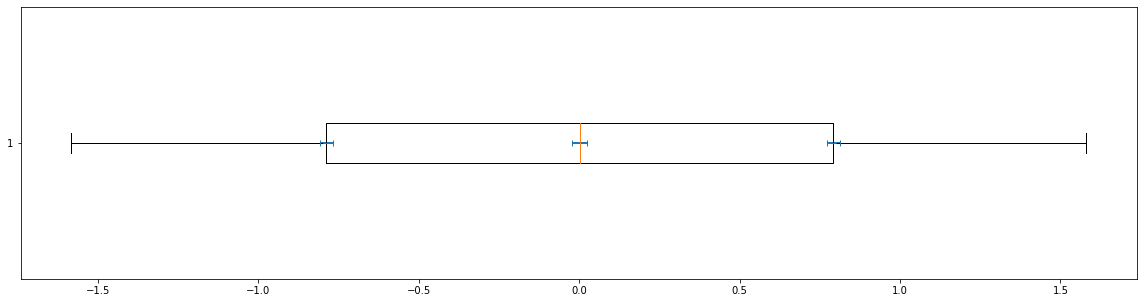

In [ ]:
get_boxplot(gamma, qn, p_conf_intervals)

In [ ]:
def get_outliers(feature):
    interquartile_range = qn[3] - qn[1]
    upper = qn[3] + 1.5 * interquartile_range
    lower = qn[1] - 1.5 * interquartile_range
    return feature[(feature > upper) | (feature < lower)]

In [ ]:
outliers = get_outliers(gamma)
print(f'Outliers count: {outliers.size}')

Outliers count: 0


Step 4. Theoretical distributions that could describe sample on a basis of non-parametric analysis result  

In [ ]:
dists = [st.beta, st.gennorm, st.ksone, st.mielke, st.powerlaw, st.tukeylambda]

Step 5. Estimate parameteres of chosen distributions using methods of maximum likelihood and least squares method  

Maximum likelihood estimation

In [ ]:
def create_dist_plots(feature, dists):
    dist_params = []
    n_dists = len(dists)
    figure, axes = plt.subplots(1, n_dists, figsize=(n_dists * 4, 3))
    feature_max = feature.max()
    feature_min = feature.min()

    for dist, ax in zip(dists, axes):
        x = np.linspace(feature_min, feature_max)
        params = dist.fit(feature)
        dist_params.append(params)
        pdf = dist.pdf(x, *params)
        ax.hist(feature, bins=n_bins, density=True)
        ax.plot(x, pdf, 'r')
        ax.title.set_text(dist.__class__.__name__[:-4])
    return dist_params

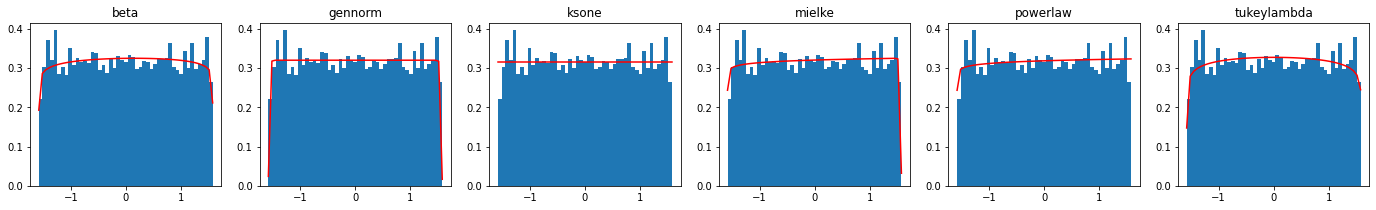

In [ ]:
dist_params = create_dist_plots(gamma, dists)

Least squares method

In [ ]:
def create_dist_plots_ls(feature, dists, p0s):
    n_dists = len(dists)
    figure, axes = plt.subplots(1, n_dists, figsize=(n_dists * 4, 3))
    feature_max = feature.max()
    feature_min = feature.min()
    histogram = np.histogram(gamma, bins=n_bins, density=True)
    for dist, ax, p0 in zip(dists, axes, p0s):
        x = np.linspace(feature_min, feature_max)
        popt, _ = scipy.optimize.curve_fit(dist.pdf, (histogram[1][1:] + histogram[1][:-1]) / 2, histogram[0], p0=p0)
        pdf = dist.pdf(x, *popt)
        ax.hist(feature, bins=n_bins, density=True)
        ax.plot(x, pdf, 'r')
        ax.title.set_text(dist.__class__.__name__[:-4])

In [ ]:
p0s = [[1, 1, -1.5, 3],
       [141, 0, 2],
       [1, -1.6, 3],
       [1, 371, -2, 3],
       [1, -2, 3],
       [1, 0, 1]]

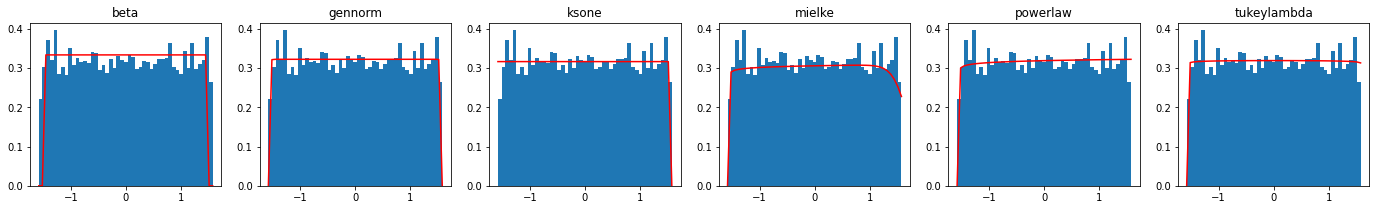

In [ ]:
create_dist_plots_ls(gamma, dists, p0s)

Step 6. Validate your estimated parameters using QQ biplots  

In [ ]:
def create_qq_plots(feature, dists, dist_params):
    n_dists = len(dists)
    figure, axes = plt.subplots(1, n_dists, figsize=(n_dists * 4, 3))
    feature_max = feature.max()
    feature_min = feature.min()
    x = np.linspace(feature_min, feature_max)
    percs = np.linspace(0, 100, 31)
    qn = np.percentile(feature, percs)

    for dist, dist_params_, ax in zip(dists, dist_params, axes):
        qn_dist = dist.ppf(percs / 100.0, *dist_params_)
        ax.plot(qn, qn_dist, ls="", marker="o", markersize=6)
        ax.plot(x, x, color="k", ls="--")
        ax.set_xlim(feature_min, feature_max)
        ax.set_ylim(feature_min, feature_max)
        ax.set_xlabel('Empirical distribution')
        ax.set_ylabel('Theoretical distribution')
        ax.title.set_text(dist.__class__.__name__[:-4])

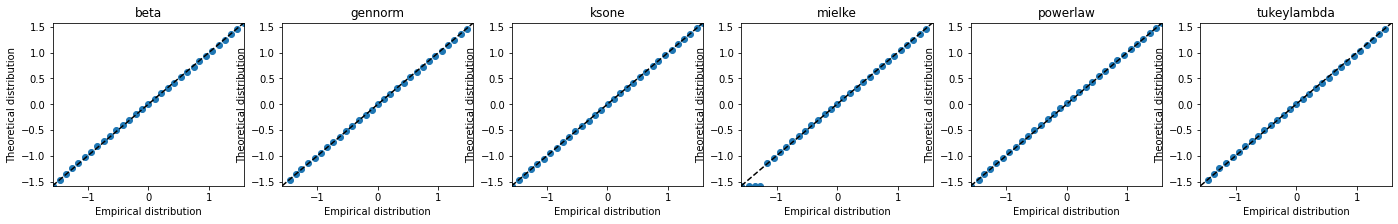

In [ ]:
create_qq_plots(gamma, dists, dist_params)

Step 7. Validate your estimate correctness of fitted distributions using at least 2 statictical tests

In [ ]:
def tests(feature, dists, dist_params):
    for dist, dist_param_ in zip(dists, dist_params):
        print(f'{dist.__class__.__name__[:-4]}')
        x = np.linspace(np.min(feature), np.max(feature))
        params = dist.fit(feature)
        pdf = dist.pdf(x, *params)
        ks = st.kstest(feature, dist.__class__.__name__[:-4], params, N=100)
        cramervonmises = st.cramervonmises(feature, dist.__class__.__name__[:-4], params)
        print(ks)
        print(cramervonmises)

In [ ]:
tests(gamma, dists, dist_params)

beta
KstestResult(statistic=0.009462315915105435, pvalue=0.2287835171205841)
CramerVonMisesResult(statistic=0.29668047759935884, pvalue=0.13811711911870095)
gennorm
KstestResult(statistic=0.007485311709904852, pvalue=0.5061532249182663)
CramerVonMisesResult(statistic=0.15348739566292566, pvalue=0.3791261644385727)
ksone
KstestResult(statistic=0.007939402683525523, pvalue=0.43027011075121246)
CramerVonMisesResult(statistic=0.07237050067897757, pvalue=0.7371076020690448)
mielke
KstestResult(statistic=0.008410203839881059, pvalue=0.35881175714227664)
CramerVonMisesResult(statistic=0.16779737789828103, pvalue=0.3396272800746465)
powerlaw
KstestResult(statistic=0.010645670466498891, pvalue=0.12890624946988316)
CramerVonMisesResult(statistic=0.3069301079397724, pvalue=0.1292450786026883)
tukeylambda
KstestResult(statistic=0.010813645971996536, pvalue=0.11816233460507564)
CramerVonMisesResult(statistic=0.4303713478854808, pvalue=0.06014011479723602)


### Penumbral Magnitude

Step 2. Non-parametric estimation of PDF in form of histogram and using kernel density function

In [ ]:
penumbral_magnitude = subsample['Penumbral Magnitude']

In [ ]:
n_bins = get_bin_count(penumbral_magnitude)

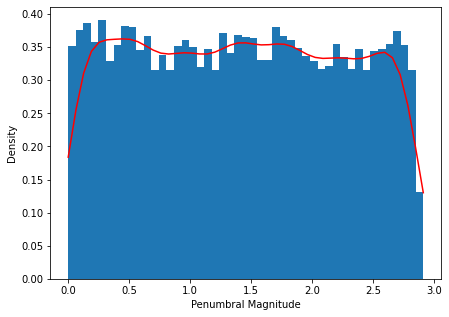

In [ ]:
hist_and_kde(penumbral_magnitude, 'Penumbral Magnitude')

Step 3. Estimation of order statistics and their representation as boxplot.

In [ ]:
get_max_min(penumbral_magnitude)

2.9089 - max number of Penumbral Magnitude
0.0004 - min number of Penumbral Magnitude


In [ ]:
percs = np.linspace(0, 100, 5)
qn = np.percentile(penumbral_magnitude, percs)
p_conf_intervals = conf_intervals(penumbral_magnitude, qn)

0.684 +/- 0.019 - confidence interval for 25.0% quantile at 95% confidence level
1.417 +/- 0.021 - confidence interval for 50.0% quantile at 95% confidence level
2.137 +/- 0.019 - confidence interval for 75.0% quantile at 95% confidence level


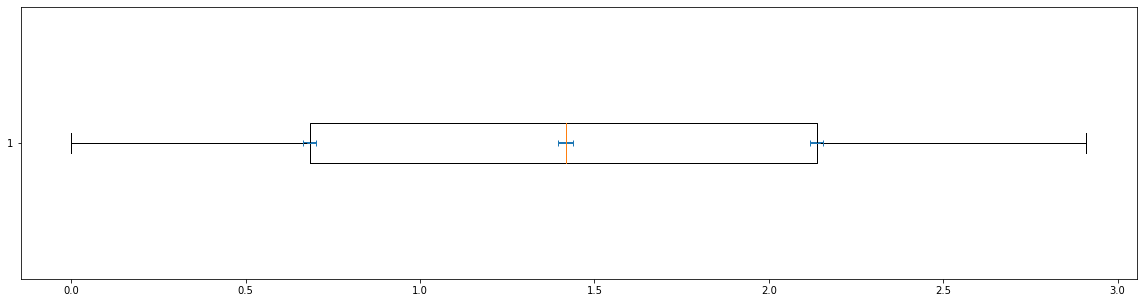

In [ ]:
get_boxplot(penumbral_magnitude, qn, p_conf_intervals)

In [ ]:
outliers = get_outliers(penumbral_magnitude)
print(f'Outliers count: {outliers.size}')

Outliers count: 0


Step 4. Theoretical distributions that could describe sample on a basis of non-parametric analysis result

In [ ]:
dists = [st.beta, st.exponweib, st.gengamma, st.mielke]

Step 5. Estimate parameteres of chosen distributions using methods of maximum likelihood and least squares method  

Maximum likelihood estimation

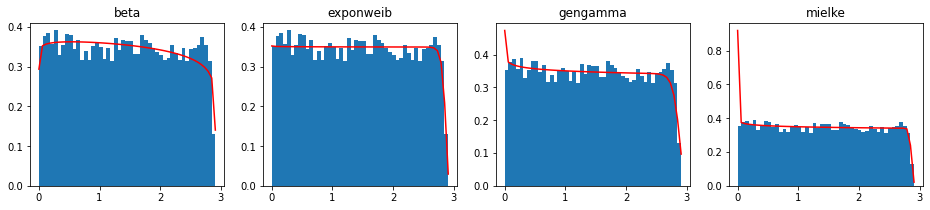

In [ ]:
dist_params = create_dist_plots(penumbral_magnitude, dists)

Least squares method

In [ ]:
p0s = [[1, 1, 0.1, 2.8],
       [0.01, 67, 0, 2],
       [0.02, 42, 0, 2],
       [1,172, 0, 3]]

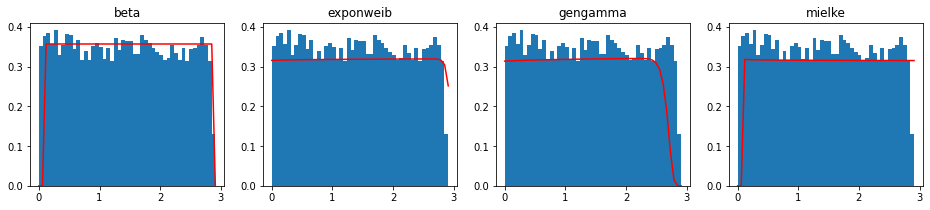

In [ ]:
create_dist_plots_ls(penumbral_magnitude, dists, p0s)

Heavily dependent on p0, as it may get stuck in local minimum

Step 6. Validate your estimated parameters using QQ biplots  

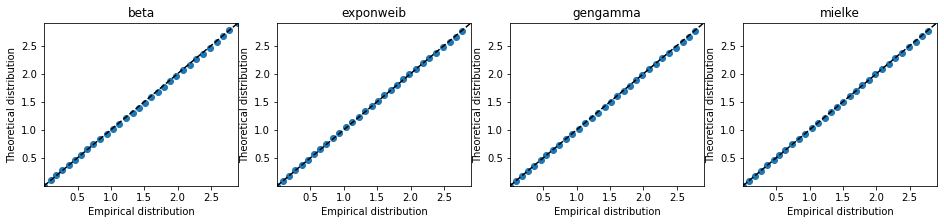

In [ ]:
create_qq_plots(penumbral_magnitude, dists, dist_params)

Step 7. Validate your estimate correctness of fitted distributions using at least 2 statictical tests

In [ ]:
tests(penumbral_magnitude, dists, dist_params)

beta
KstestResult(statistic=0.011101338159772933, pvalue=0.10147540293425117)
CramerVonMisesResult(statistic=0.5209149665904036, pvalue=0.03526139582954624)
exponweib
KstestResult(statistic=0.008818029038794306, pvalue=0.3034914229665462)
CramerVonMisesResult(statistic=0.18948201103549075, pvalue=0.28880922718555146)
gengamma
KstestResult(statistic=0.009216046214294171, pvalue=0.25552836608030205)
CramerVonMisesResult(statistic=0.1919174985033672, pvalue=0.28369243278025824)
mielke
KstestResult(statistic=0.006584513174423434, pvalue=0.6697715894326708)
CramerVonMisesResult(statistic=0.07995764038941507, pvalue=0.6921089247957903)


### Umbral Magnitude

Step 2. Non-parametric estimation of PDF in form of histogram and using kernel density function

In [ ]:
umbral_magnitude = subsample['Umbral Magnitude']

In [ ]:
n_bins = get_bin_count(umbral_magnitude)

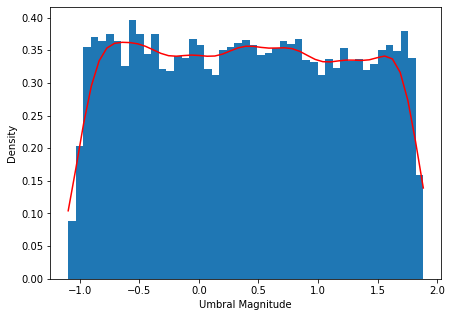

In [ ]:
hist_and_kde(umbral_magnitude, 'Umbral Magnitude')

Step 3. Estimation of order statistics and their representation as boxplot.

In [ ]:
get_max_min(umbral_magnitude)

1.8821 - max number of Umbral Magnitude
-1.0958 - min number of Umbral Magnitude


In [ ]:
percs = np.linspace(0, 100, 5)
qn = np.percentile(umbral_magnitude, percs)
p_conf_intervals = conf_intervals(umbral_magnitude, qn)

-0.334 +/- 0.019 - confidence interval for 25.0% quantile at 95% confidence level
0.400 +/- 0.021 - confidence interval for 50.0% quantile at 95% confidence level
1.118 +/- 0.020 - confidence interval for 75.0% quantile at 95% confidence level


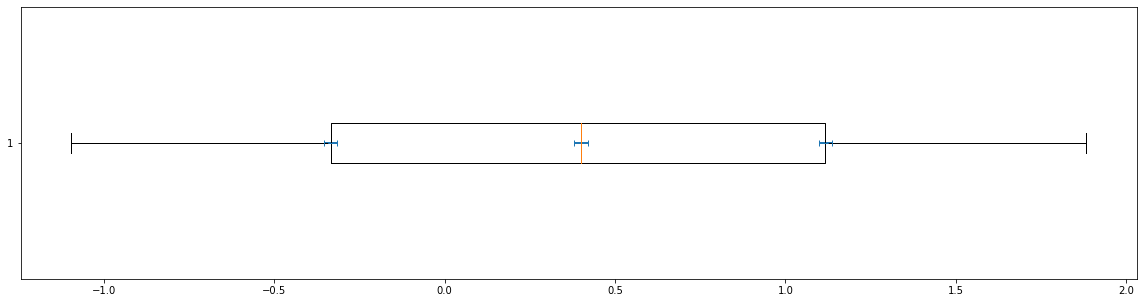

In [ ]:
get_boxplot(umbral_magnitude, qn, p_conf_intervals)

In [ ]:
outliers = get_outliers(umbral_magnitude)
print(f'Outliers count: {outliers.size}')

Outliers count: 0


Step 4. Theoretical distributions that could describe sample on a basis of non-parametric analysis result  
Step 5. Estimate parameteres of chosen distributions using methods of maximum likelihood and least squares method  

Maximum likelihood estimation

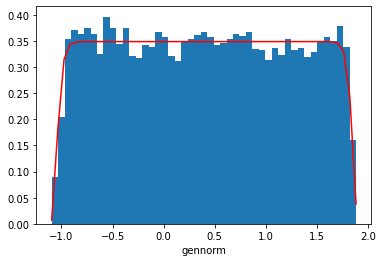

In [ ]:
umbral_max = umbral_magnitude.max()
umbral_min = umbral_magnitude.min()
x = np.linspace(umbral_min, umbral_max)
params = st.gennorm.fit(umbral_magnitude)
pdf = st.gennorm.pdf(x, *params)
plt.hist(umbral_magnitude, bins=n_bins, density=True)
plt.plot(x, pdf, 'r')
plt.xlabel('gennorm')
plt.show()

Least squares method

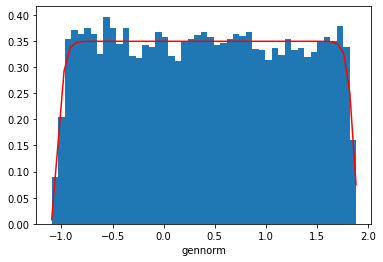

In [ ]:
histogram = np.histogram(umbral_magnitude, bins=n_bins, density=True)
params_ls, _ = scipy.optimize.curve_fit(st.gennorm.pdf, (histogram[1][1:] + histogram[1][:-1]) / 2, histogram[0], p0=[1, 1, 1])
x = np.linspace(umbral_min, umbral_max)
pdf = st.gennorm.pdf(x, *params_ls)
plt.hist(umbral_magnitude, bins=n_bins, density=True)
plt.plot(x, pdf, 'r')
plt.xlabel('gennorm')
plt.show()

Step 6. Validate your estimated parameters using QQ biplots  

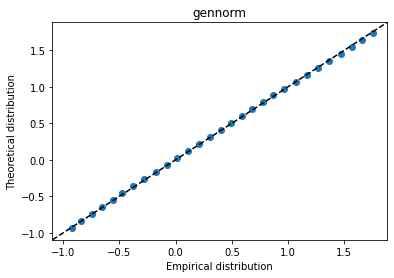

In [ ]:
percs = np.linspace(0, 100, 31)
qn = np.percentile(umbral_magnitude, percs)

qn_dist = st.gennorm.ppf(percs / 100.0, *params)
plt.plot(qn, qn_dist, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlim(umbral_min, umbral_max)
plt.ylim(umbral_min, umbral_max)
plt.xlabel('Empirical distribution')
plt.ylabel('Theoretical distribution')
plt.title('gennorm')
plt.show()

Step 7. Validate your estimate correctness of fitted distributions using at least 2 statictical tests

In [ ]:
x = np.linspace(np.min(umbral_magnitude), np.max(umbral_magnitude))
params = st.gennorm.fit(umbral_magnitude)
pdf = st.gennorm.pdf(x, *params)

ks = scipy.stats.kstest(umbral_magnitude, 'gennorm', params, N=100)
cramervonmises = st.cramervonmises(umbral_magnitude, 'gennorm', params)
print(ks)
print(cramervonmises)

KstestResult(statistic=0.007153140894162524, pvalue=0.5651246462712604)
CramerVonMisesResult(statistic=0.13890696071922104, pvalue=0.4252257079254228)
